# DQN Rotation Alignment Agent (Kornia + PyTorch)

This notebook implements a DQN agent that learns to align a source image to a target image via rotation, or declare a mismatch when the images are fundamentally different (for example mirrored). The environment uses kornia for differentiable GPU-accelerated rotation and keeps all rotation ops on the active device.


**Dataset used in this notebook**
The training data here is synthetic: each target image is a 3×H×W tensor of colored rectangles on a black background. A source image is created by optionally mirroring the target horizontally (to make a "different" sample) and then rotating by a random angle. This produces two classes:
- **Same (rotated)**: source is only rotated from target.
- **Mirrored (different)**: source is mirrored then rotated.

You can replace the sampler with your real dataset by supplying `(source, target, is_mirrored)` pairs.


In [1]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [90]:
import math
import random
from typing import Callable, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import kornia as K

import gymnasium as gym
import imageio.v2 as imageio

In [91]:
def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


def set_seed(seed: int = 0) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def build_state(source: torch.Tensor, target: torch.Tensor, angle_deg=None) -> torch.Tensor:
    # Build state by concatenating source, target, and a constant angle channel.
    # Handles batch expansion of target/angle if needed.
    if source.dim() == 3:
        source = source.unsqueeze(0)
    if target.dim() == 3:
        target = target.unsqueeze(0)
    if target.shape[0] == 1 and source.shape[0] > 1:
        target = target.expand(source.shape[0], -1, -1, -1)

    state = torch.cat([source, target], dim=1)

    if angle_deg is None:
        return state

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=state.device, dtype=state.dtype)
    else:
        angle = angle_deg.to(device=state.device, dtype=state.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and state.shape[0] > 1:
        angle = angle.repeat(state.shape[0])

    angle_norm = (angle % 360.0) / 360.0
    angle_ch = angle_norm.view(-1, 1, 1, 1).expand(-1, 1, state.shape[2], state.shape[3])
    return torch.cat([state, angle_ch], dim=1)


def rotate_tensor(img: torch.Tensor, angle_deg, pad_to_diag: bool = True) -> torch.Tensor:
    # Rotate image(s) by angle(s) in degrees using kornia.
    # If pad_to_diag=True, pad to the diagonal size before rotating, then center-crop.
    if img.dim() == 3:
        img_b = img.unsqueeze(0)
    else:
        img_b = img

    if not torch.is_tensor(angle_deg):
        angle = torch.tensor([angle_deg], device=img_b.device, dtype=img_b.dtype)
    else:
        angle = angle_deg.to(device=img_b.device, dtype=img_b.dtype)

    if angle.dim() == 0:
        angle = angle.unsqueeze(0)
    if angle.numel() == 1 and img_b.shape[0] > 1:
        angle = angle.repeat(img_b.shape[0])

    b, c, h, w = img_b.shape
    if pad_to_diag:
        diag = int(math.ceil(math.sqrt(h * h + w * w)))
        pad_h = max(0, diag - h)
        pad_w = max(0, diag - w)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        if pad_h > 0 or pad_w > 0:
            img_p = F.pad(img_b, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=0.0)
        else:
            img_p = img_b
    else:
        img_p = img_b

    rotated = K.geometry.transform.rotate(img_p, angle)

    if pad_to_diag:
        hh, ww = h, w
        y0 = (rotated.shape[2] - hh) // 2
        x0 = (rotated.shape[3] - ww) // 2
        rotated = rotated[:, :, y0:y0 + hh, x0:x0 + ww]

    return rotated if img.dim() == 4 else rotated.squeeze(0)


device = get_device()
print("Device:", device)


Device: mps


In [92]:
class RotationEnv(gym.Env):
    # Observation: (7, H, W) = [source(3), target(3), angle(1)] in [0, 1], torch tensor on device.
    # Actions:
    #   0: rotate CW  (delta = -10 deg)
    #   1: rotate CCW (delta = +10 deg)
    #   2: rotate CW  (delta = -5 deg)
    #   3: rotate CCW (delta = +5 deg)
    #   4: rotate CW  (delta = -1 deg)
    #   5: rotate CCW (delta = +1 deg)
    #   6: commit match (only allowed if error < epsilon)
    #   7: commit mismatch (only allowed after N steps without improvement)

    metadata = {"render_modes": []}

    def __init__(
        self,
        image_shape: Tuple[int, int, int],
        max_steps: int = 180,
        epsilon: float = 0.03,
        mismatch_patience: int = 20,
        improve_eps: float = 1e-6,
        device: Optional[torch.device] = None,
        pair_sampler: Optional[Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]] = None,
    ):
        super().__init__()
        self.image_shape = image_shape  # (3, H, W)
        self.max_steps = max_steps
        self.epsilon = epsilon
        self.mismatch_patience = mismatch_patience
        self.improve_eps = improve_eps
        self.device = device or get_device()
        self.pair_sampler = pair_sampler

        _, h, w = image_shape
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(7, h, w),
            dtype=np.float32,
        )
        self.action_space = gym.spaces.Discrete(8)

        self.base_source = None
        self.target = None
        self.current_source = None
        self.current_angle = 0.0
        self.is_mirrored = False
        self.step_count = 0
        self.prev_error = None
        self.no_improve_steps = 0

    def _set_pair(self, source: torch.Tensor, target: torch.Tensor, is_mirrored: bool) -> None:
        self.base_source = source.to(self.device).float().clamp(0, 1)
        self.target = target.to(self.device).float().clamp(0, 1)
        self.is_mirrored = bool(is_mirrored)
        self.current_angle = 0.0
        self.current_source = self.base_source
        self.step_count = 0
        self.prev_error = self._alignment_error().detach()
        self.no_improve_steps = 0

    def _obs(self) -> torch.Tensor:
        return build_state(self.current_source, self.target, self.current_angle)[0]

    def _alignment_error(self) -> torch.Tensor:
        return torch.mean((self.current_source - self.target) ** 2)

    def _update_no_improve(self, err: torch.Tensor) -> None:
        if err < (self.prev_error - self.improve_eps):
            self.no_improve_steps = 0
        else:
            self.no_improve_steps += 1
        self.prev_error = err.detach()

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        options = options or {}

        if "pair" in options:
            source, target, is_mirrored = options["pair"]
        elif "source" in options and "target" in options:
            source = options["source"]
            target = options["target"]
            is_mirrored = bool(options.get("is_mirrored", False))
        elif self.pair_sampler is not None:
            source, target, is_mirrored = self.pair_sampler(self.device)
        else:
            raise ValueError("No pair provided. Pass options={pair: (...)} or set pair_sampler.")

        self._set_pair(source, target, is_mirrored)
        info = {"angle": self.current_angle}
        return self._obs(), info

    def step(self, action: int):
        terminated = False
        reward = 0.0
        err = self._alignment_error()

        if action == 0 or action == 1:
            delta = -10.0 if action == 0 else 10.0
            self.current_angle = (self.current_angle + delta) % 360.0
            self.current_source = rotate_tensor(self.base_source, self.current_angle)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_no_improve(err)
        elif action == 2 or action == 3:
            delta = -5.0 if action == 2 else 5.0
            self.current_angle = (self.current_angle + delta) % 360.0
            self.current_source = rotate_tensor(self.base_source, self.current_angle)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_no_improve(err)
        elif action == 4 or action == 5:
            delta = -1.0 if action == 4 else 1.0
            self.current_angle = (self.current_angle + delta) % 360.0
            self.current_source = rotate_tensor(self.base_source, self.current_angle)
            err = self._alignment_error()
            reward = -float(err.detach())
            self._update_no_improve(err)
        elif action == 6:
            if err < self.epsilon:
                is_match = (not self.is_mirrored)
                reward = 100.0 if is_match else -100.0
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        elif action == 7:
            if self.no_improve_steps >= self.mismatch_patience:
                reward = 100.0 if self.is_mirrored else -100.0
                terminated = True
            else:
                reward = -float(err.detach())
                self._update_no_improve(err)
        else:
            raise ValueError(f"Invalid action: {action}")

        self.step_count += 1
        truncated = (self.step_count >= self.max_steps) and (not terminated)

        info = {
            "angle": self.current_angle,
            "error": float(err.detach().cpu()),
            "is_mirrored": self.is_mirrored,
            "no_improve_steps": self.no_improve_steps,
        }
        return self._obs(), float(reward), terminated, truncated, info


In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_shape: Tuple[int, int, int], num_actions: int = 8):
        super().__init__()
        c, h, w = input_shape
        self.features = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        with torch.no_grad()
            dummy = torch.zeros(1, c, h, w)
            out = self.features(dummy)
            conv_out = out.view(1, -1).shape[1]
        self.head = nn.Sequential(
            nn.Linear(conv_out, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_actions),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.head(x)


In [94]:
class ReplayBuffer:
    def __init__(self, capacity: int, state_shape: Tuple[int, int, int], store_uint8: bool = True):
        self.capacity = capacity
        self.state_shape = state_shape
        self.store_uint8 = store_uint8

        state_dtype = torch.uint8 if store_uint8 else torch.float32
        self.states = torch.empty((capacity, *state_shape), dtype=state_dtype)
        self.next_states = torch.empty((capacity, *state_shape), dtype=state_dtype)
        self.actions = torch.empty((capacity,), dtype=torch.int64)
        self.rewards = torch.empty((capacity,), dtype=torch.float32)
        self.dones = torch.empty((capacity,), dtype=torch.uint8)

        self.idx = 0
        self.size = 0

    def push(self, state: torch.Tensor, action: int, reward: float, next_state: torch.Tensor, done: bool) -> None:
        if self.store_uint8:
            s = (state.detach().cpu().clamp(0, 1) * 255).to(torch.uint8)
            ns = (next_state.detach().cpu().clamp(0, 1) * 255).to(torch.uint8)
        else:
            s = state.detach().cpu().float()
            ns = next_state.detach().cpu().float()

        self.states[self.idx] = s
        self.next_states[self.idx] = ns
        self.actions[self.idx] = int(action)
        self.rewards[self.idx] = float(reward)
        self.dones[self.idx] = int(done)

        self.idx = (self.idx + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int, device: torch.device):
        idx = torch.randint(0, self.size, (batch_size,))
        states = self.states[idx].to(device)
        next_states = self.next_states[idx].to(device)
        if self.store_uint8:
            states = states.float() / 255.0
            next_states = next_states.float() / 255.0
        actions = self.actions[idx].to(device)
        rewards = self.rewards[idx].to(device)
        dones = self.dones[idx].to(device).float()
        return states, actions, rewards, next_states, dones


In [95]:
def random_target_image(h: int, w: int, num_shapes: int = 4) -> torch.Tensor:
    img = torch.zeros(3, h, w)
    for _ in range(num_shapes):
        color = torch.rand(3, 1, 1)
        y0 = random.randint(0, h - 8)
        x0 = random.randint(0, w - 8)
        y1 = min(h, y0 + random.randint(6, h // 2))
        x1 = min(w, x0 + random.randint(6, w // 2))
        img[:, y0:y1, x0:x1] = color
    return img


def make_pair_sampler(
    image_shape: Tuple[int, int, int],
    mirror_prob: float = 0.5,
    angle_step: float = 5.0,
) -> Callable[[torch.device], Tuple[torch.Tensor, torch.Tensor, bool]]:
    _, h, w = image_shape

    def sampler(device: torch.device):
        target = random_target_image(h, w)
        is_mirrored = random.random() < mirror_prob
        source = torch.flip(target, dims=[2]) if is_mirrored else target.clone()
        angle = random.choice(np.arange(0.0, 360.0, angle_step))
        source = rotate_tensor(source, angle)
        return source, target, is_mirrored

    return sampler


In [96]:
def select_action(qnet: nn.Module, state: torch.Tensor, epsilon: float, action_space) -> int:
    if random.random() < epsilon:
        return action_space.sample()
    with torch.no_grad():
        if state.dim() == 3:
            state = state.unsqueeze(0)
        q = qnet(state)
        return int(q.argmax(dim=1).item())


def train_dqn(
    env: RotationEnv,
    qnet: QNetwork,
    target_net: QNetwork,
    buffer: ReplayBuffer,
    episodes: int = 2000,
    batch_size: int = 64,
    gamma: float = 0.99,
    eps_start: float = 1.0,
    eps_end: float = 0.05,
    eps_decay_episodes: int = 1000,
    target_update_steps: int = 1000,
    lr: float = 1e-4,
    max_steps: int = 180,
    log_interval: int = 50,
    plot_loss: bool = True,
    loss_window: int = 100,
):
    device = next(qnet.parameters()).device
    optimizer = torch.optim.AdamW(qnet.parameters(), lr=lr)
    huber = nn.SmoothL1Loss()

    qnet.train()
    target_net.eval()

    global_step = 0
    rewards_history = []
    losses = []

    # logging accumulators (per interval)
    win_rewards = []
    win_improve = []
    win_commit_err = []
    win_commit_correct = []
    win_commit_total = 0
    win_match_blocked = 0
    win_match_attempts = 0

    for ep in range(1, episodes + 1):
        epsilon = eps_end + (eps_start - eps_end) * max(0.0, (eps_decay_episodes - ep) / eps_decay_episodes)
        state, _ = env.reset()
        ep_reward = 0.0

        prev_err = float(env._alignment_error().detach().cpu())
        rotate_improve = 0
        rotate_steps = 0
        commit_err = None
        commit_correct = None

        for _ in range(max_steps):
            action = select_action(qnet, state, epsilon, env.action_space)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            buffer.push(state, action, reward, next_state, done)
            state = next_state
            ep_reward += reward
            global_step += 1

            err = float(info.get("error", prev_err))
            if action in (0, 1):
                rotate_steps += 1
                if (prev_err - err) > 0:
                    rotate_improve += 1
                prev_err = err
            elif action == 6:
                win_match_attempts += 1
                if not terminated:
                    win_match_blocked += 1
                else:
                    commit_err = err
                    commit_correct = (not info.get("is_mirrored", False)) and (err < env.epsilon)
            elif action == 7:
                commit_err = err
                commit_correct = info.get("is_mirrored", False)

            if buffer.size >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size, device)
                q_values = qnet(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q = target_net(next_states).max(dim=1)[0]
                    target = rewards + gamma * (1.0 - dones) * next_q
                loss = huber(q_values, target)
                losses.append(float(loss.item()))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if global_step % target_update_steps == 0:
                target_net.load_state_dict(qnet.state_dict())

            if done:
                break

        rewards_history.append(ep_reward)
        win_rewards.append(ep_reward)

        if rotate_steps > 0:
            win_improve.append(rotate_improve / rotate_steps)

        if commit_err is not None:
            win_commit_err.append(commit_err)
            win_commit_total += 1
            if commit_correct:
                win_commit_correct.append(1)
            else:
                win_commit_correct.append(0)

        if ep % log_interval == 0:
            avg_reward = sum(win_rewards) / len(win_rewards)
            avg_improve = sum(win_improve) / len(win_improve) if win_improve else 0.0
            commit_rate = (win_commit_total / log_interval) if log_interval > 0 else 0.0
            commit_acc = (sum(win_commit_correct) / len(win_commit_correct)) if win_commit_correct else 0.0
            avg_commit_err = (sum(win_commit_err) / len(win_commit_err)) if win_commit_err else float("nan")
            match_block_rate = (win_match_blocked / win_match_attempts) if win_match_attempts > 0 else 0.0

            print(
                f"Episode {ep:4d} | eps {epsilon:.3f} | avgR {avg_reward:.1f} "
                f"| improve {avg_improve:.2f} | commit_rate {commit_rate:.2f} "
                f"| commit_acc {commit_acc:.2f} | commit_err {avg_commit_err:.4f} "
                f"| match_blocked {match_block_rate:.2f}"
            )

            win_rewards = []
            win_improve = []
            win_commit_err = []
            win_commit_correct = []
            win_commit_total = 0
            win_match_blocked = 0
            win_match_attempts = 0

    if plot_loss and len(losses) > 0:
        import matplotlib.pyplot as plt

        plt.figure(figsize=(6, 3))
        plt.plot(losses, alpha=0.4, label="TD loss")
        if len(losses) >= loss_window:
            kernel = np.ones(loss_window) / float(loss_window)
            smooth = np.convolve(np.array(losses), kernel, mode="valid")
            plt.plot(range(loss_window - 1, len(losses)), smooth, label=f"MA({loss_window})")
        plt.xlabel("Training updates")
        plt.ylabel("Loss")
        plt.title("DQN Training Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return rewards_history


Episode   50 | eps 0.953 | avgR -9.9 | improve 0.52 | commit_rate 1.00 | commit_acc 0.68 | commit_err 0.1067 | match_blocked 0.99
Episode  100 | eps 0.905 | avgR -5.3 | improve 0.51 | commit_rate 1.00 | commit_acc 0.50 | commit_err 0.1004 | match_blocked 0.99
Episode  150 | eps 0.858 | avgR 7.2 | improve 0.52 | commit_rate 1.00 | commit_acc 0.68 | commit_err 0.0793 | match_blocked 0.99
Episode  200 | eps 0.810 | avgR 1.7 | improve 0.54 | commit_rate 1.00 | commit_acc 0.66 | commit_err 0.0869 | match_blocked 0.99
Episode  250 | eps 0.762 | avgR 1.2 | improve 0.58 | commit_rate 1.00 | commit_acc 0.72 | commit_err 0.0795 | match_blocked 0.98
Episode  300 | eps 0.715 | avgR 17.0 | improve 0.57 | commit_rate 1.00 | commit_acc 0.78 | commit_err 0.0781 | match_blocked 0.98
Episode  350 | eps 0.667 | avgR 22.2 | improve 0.55 | commit_rate 1.00 | commit_acc 0.78 | commit_err 0.0623 | match_blocked 0.98
Episode  400 | eps 0.620 | avgR 2.4 | improve 0.55 | commit_rate 1.00 | commit_acc 0.74 | com

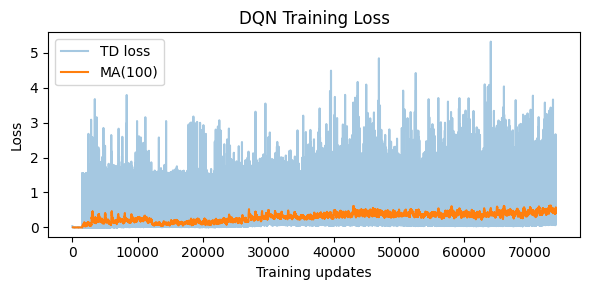

In [97]:
set_seed(0)

H, W = 64, 64
image_shape = (3, H, W)

sampler = make_pair_sampler(image_shape=image_shape, mirror_prob=0.5, angle_step=5.0)

env = RotationEnv(
    image_shape=image_shape,
    max_steps=180,
    epsilon=0.03,
    # step_penalty=-0.1,
    device=device,
    pair_sampler=sampler,
)

qnet = QNetwork(input_shape=(7, H, W)).to(device)
target_net = QNetwork(input_shape=(7, H, W)).to(device)
target_net.load_state_dict(qnet.state_dict())

buffer = ReplayBuffer(capacity=10_000, state_shape=(7, H, W), store_uint8=True)

# Uncomment to train
rewards = train_dqn(env, qnet, target_net, buffer, episodes=500)

In [ ]:
def render_pair_frame(source: torch.Tensor, target: torch.Tensor) -> np.ndarray:
    # Return a side-by-side frame (H, 2W, 3) as uint8.
    src = (source.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    tgt = (target.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    return np.concatenate([src, tgt], axis=1)


def rollout_and_save_gif(
    env: RotationEnv,
    qnet: QNetwork,
    out_path: str = "gifs/rotation_episode.gif",
    max_steps: int = 360,
    fps: int = 8,
):
    state, _ = env.reset()
    frames = []

    for _ in range(max_steps):
        frames.append(render_pair_frame(env.current_source, env.target))
        action = select_action(qnet, state, epsilon=0.05, action_space=env.action_space)
        state, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            frames.append(render_pair_frame(env.current_source, env.target))
            break

    imageio.mimsave(out_path, frames, fps=fps)
    return out_path

# Uncomment to generate a GIF (after training)
gif_path = rollout_and_save_gif(env, qnet, out_path="gifs/rotation_episode.gif")
gif_path

'rotation_episode.gif'

In [99]:
# Evaluate accuracy on 100 random pairs (matchable vs mirrored)
correct = 0
n = 100
temp_epsilon = env.epsilon # same as training, but play around with 0.01 - 0.07

# Allow longer alignment during evaluation
prev_max_steps = env.max_steps
eval_max_steps = max(prev_max_steps, 180)
env.max_steps = eval_max_steps

for _ in range(n):
    state, _ = env.reset()
    terminated = False
    info = {}
    action = None

    for _ in range(eval_max_steps):
        action = select_action(qnet, state, epsilon=0.0, action_space=env.action_space)
        state, _, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    if not terminated:
        # Force a commit at the end based on final error
        if (not info.get("is_mirrored", False)) and (info.get("error", 1.0) < temp_epsilon):
            action = 6
        else:
            action = 7

    if action == 6:
        is_correct = (not info.get("is_mirrored", False)) and (info.get("error", 1.0) < temp_epsilon)
    elif action == 7:
        is_correct = info.get("is_mirrored", False)
    else:
        is_correct = False

    if is_correct:
        correct += 1

env.max_steps = prev_max_steps

print(f"Accuracy: {correct}/{n}")


Accuracy: 65/100


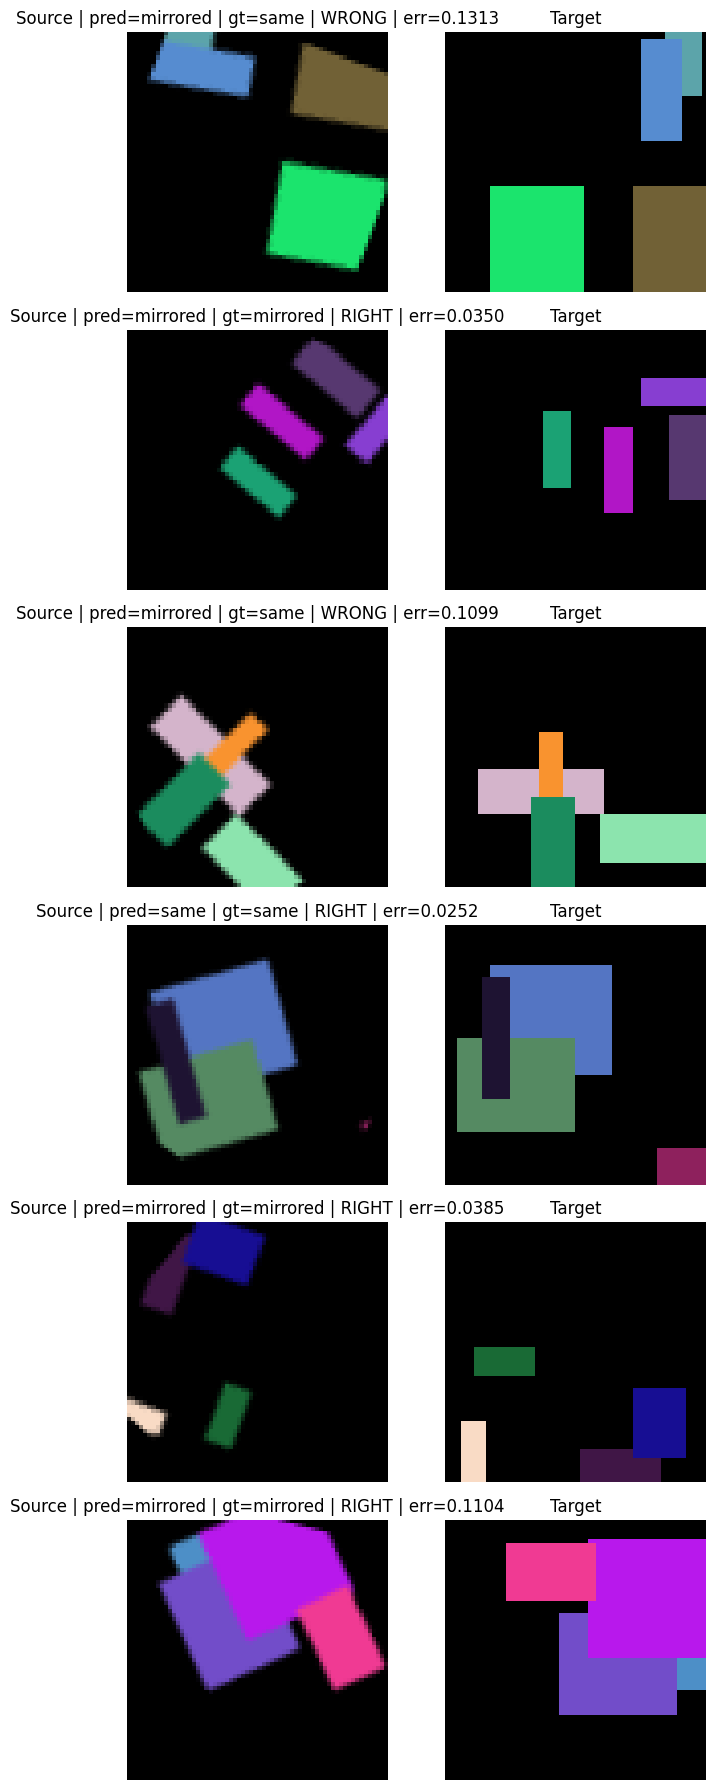

In [100]:
# Visualize a few samples (both mirrored and same) with correctness
import matplotlib.pyplot as plt

num_each = 3
samples = [False] * num_each + [True] * num_each  # False = same, True = mirrored
random.shuffle(samples)

angles = [a for a in range(0, 360, 5)]

viz = []
for is_mirrored in samples:
    target = random_target_image(H, W)
    base = torch.flip(target, dims=[2]) if is_mirrored else target
    angle = random.choice(angles)
    source = rotate_tensor(base, angle)

    state, _ = env.reset(options={"source": source, "target": target, "is_mirrored": is_mirrored})

    terminated = False
    info = {}
    action = None

    for _ in range(max(env.max_steps, 180)):
        action = select_action(qnet, state, epsilon=0.0, action_space=env.action_space)
        state, _, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    if not terminated:
        # Force a commit at the end based on final error
        if info.get("error", 1.0) < env.epsilon:
            action = 6
        else:
            action = 7

    if action == 6:
        is_correct = (not is_mirrored) and (info.get("error", 1.0) < env.epsilon)
        pred = "same"
    elif action == 7:
        is_correct = is_mirrored
        pred = "mirrored"
    else:
        is_correct = False
        pred = "unknown"

    gt = "mirrored" if is_mirrored else "same"
    viz.append((env.current_source, env.target, pred, gt, is_correct, info.get("error", 1.0)))

rows = len(viz)
fig, axes = plt.subplots(rows, 2, figsize=(7, 3 * rows))
if rows == 1:
    axes = [axes]

for i, (src, tgt, pred, gt, ok, err) in enumerate(viz):
    src_np = src.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()
    tgt_np = tgt.clamp(0, 1).permute(1, 2, 0).detach().cpu().numpy()

    ax0 = axes[i][0] if rows > 1 else axes[0]
    ax1 = axes[i][1] if rows > 1 else axes[1]

    ax0.imshow(src_np)
    ax0.set_title(f"Source | pred={pred} | gt={gt} | {'RIGHT' if ok else 'WRONG'} | err={err:.4f}")
    ax0.axis("off")

    ax1.imshow(tgt_np)
    ax1.set_title("Target")
    ax1.axis("off")

plt.tight_layout()
plt.show()

Epsilon values: [0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06
 0.065 0.07  0.075 0.08 ]
Accuracy values: [0.52 0.55 0.56 0.6  0.61 0.63 0.63 0.61 0.61 0.64 0.63 0.61 0.59 0.58
 0.59 0.6 ]
AUC (normalized): 0.600


/var/folders/27/76q8rfwn799g95yl3x7jwbnh0000gn/T/ipykernel_60615/2506466140.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(acc_values, eps_values) / (eps_values[-1] - eps_values[0])


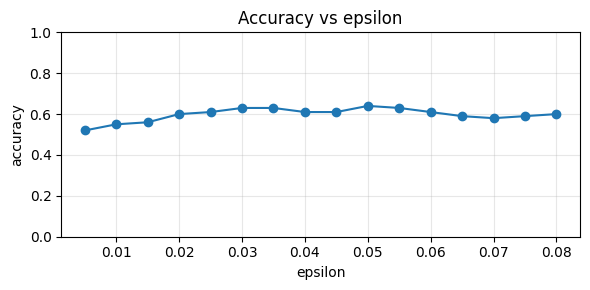

In [88]:
n = 100
prev_max_steps = env.max_steps
eval_max_steps = max(prev_max_steps, 180)
env.max_steps = eval_max_steps

# Pre-generate evaluation samples (balanced 50/50)
angles = [a for a in range(0, 360, 5)]

eval_samples = []
for _ in range(n):
    target = random_target_image(H, W)
    is_mirrored = random.random() < 0.5
    base = torch.flip(target, dims=[2]) if is_mirrored else target
    angle = random.choice(angles)
    source = rotate_tensor(base, angle)
    eval_samples.append((source, target, is_mirrored))


def run_policy(source, target, is_mirrored, max_steps):
    state, _ = env.reset(options={"source": source, "target": target, "is_mirrored": is_mirrored})
    terminated = False
    info = {}
    action = None

    for _ in range(max_steps):
        action = select_action(qnet, state, epsilon=0.0, action_space=env.action_space)
        state, _, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

    # If not terminated, force a commit based on final error
    if not terminated:
        if info.get("error", 1.0) < env.epsilon:
            action = 6
        else:
            action = 7

    return action, info


def accuracy_at_epsilon(eps):
    correct = 0
    for source, target, is_mirrored in eval_samples:
        # temporarily override epsilon
        old_eps = env.epsilon
        env.epsilon = eps
        action, info = run_policy(source, target, is_mirrored, eval_max_steps)
        env.epsilon = old_eps

        if action == 6:
            is_correct = (not is_mirrored) and (info.get("error", 1.0) < eps)
        elif action == 7:
            is_correct = is_mirrored
        else:
            is_correct = False

        if is_correct:
            correct += 1
    return correct / len(eval_samples)


eps_values = np.linspace(0.005, 0.08, 16)
acc_values = np.array([accuracy_at_epsilon(eps) for eps in eps_values])

auc = np.trapz(acc_values, eps_values) / (eps_values[-1] - eps_values[0])

print("Epsilon values:", eps_values)
print("Accuracy values:", acc_values)
print(f"AUC (normalized): {auc:.3f}")

plt.figure(figsize=(6, 3))
plt.plot(eps_values, acc_values, marker="o")
plt.xlabel("epsilon")
plt.ylabel("accuracy")
plt.title("Accuracy vs epsilon")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

env.max_steps = prev_max_steps

In [81]:
save_name = "../models/dqn_rot_angle7_act8_eps01_ms180.pt"
torch.save({
    "qnet_state_dict": qnet.state_dict(),
    "target_state_dict": target_net.state_dict(),
    "epsilon": env.epsilon,
    "max_steps": env.max_steps,
    "action_space": env.action_space.n,
    "obs_shape": env.observation_space.shape,
}, save_name)
print(f"Saved model to {save_name}")

Saved model to ../models/dqn_rot_angle7_act8_eps01_ms180.pt
